## This analysis classifies genes according to their response to three different mechanical stimulations: PS, OS, or LF flow patterns and then delineate a SARS-CoV-2 interactome

In [1]:
options(warn=-1)

homedir <- "C:/Users/breng/Desktop/final shear analysis"
funcsfile <- "shear_analysis_functions.r"

fdrname <- "./data/4 edgeR.xls"
fcanalyzed <- "./data/6 PSLFOSLF FC data.xls"
coviddb <- "./data/COVID_data/binding protein list.csv"
cytofile <- "./data/cytoscape/cytoscape_interactions.csv"
klf4seq <- "./data/2 A2B1_pvalue KLF4_over.csv"

setwd(homedir)
source(funcsfile)

suppressMessages({
    library(ggplot2)
    library(ggpubr)
    library(data.table)
    library(matrixStats)
    library(pheatmap)
    library(heatmaply)
    library(VennDiagram)
    library(ClinicalDataMineR)
    library(ConservationtextmineR)
    library(dplyr)
    library(fmsb)
    library(biomaRt)
    library(systemPipeR)
    library(Rsamtools)
    library(GenomicAlignments)
    library(rtracklayer)
    library(gridExtra)
    library(MyPackage)
    library(Gviz)
    library(rtracklayer)
    library(trackViewer)
    library(RColorBrewer)  
})

The file "4 edgeR" contains the computed fold changes from a 10 time point RNAseq experiment involving endothelial cells subjected to PS, OS, or LF.

The file "6 PSLFOSLF FC data" contains the complete cases of file 4 in addition to the gene name annotation information and the raw read counts.

In [2]:
dt1 <- fread(fdrname)
dt1 <- dt1[,!grep("(logCPM|LR)", colnames(dt1)), with = FALSE]; setkey(dt1, TranscriptID)
annotation <- fread(fcanalyzed)
annotation <- annotation[,grep("(Transcrip|Name|setA|setB)", colnames(annotation)), with = FALSE]; setkey(annotation, TranscriptID)
#dt <- merge(dt1, annotation, by = "TranscriptID")
dt <- dt1[annotation]
dt <- dt[,c(92, 1:91, 93:ncol(dt)), with = FALSE]
str(dt)

Classes 'data.table' and 'data.frame':	20450 obs. of  134 variables:
 $ GeneName          : chr  "A2M" "ACADM" "ACADS" "ACADVL" ...
 $ PS1-LF_logFC      : num  -0.2086 0.184 -0.0472 0.256 -0.1074 ...
 $ PS1-LF_PValue     : num  0.869 0.666 0.95 0.579 0.678 ...
 $ PS1-LF_FDR        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ PS2-LF_logFC      : num  -0.4536 0.0364 0.0444 0.4568 -0.191 ...
 $ PS2-LF_PValue     : num  0.731 0.934 0.952 0.32 0.47 ...
 $ PS2-LF_FDR        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ PS3-LF_logFC      : num  -0.37203 0.04507 0.00934 0.35398 -0.09053 ...
 $ PS3-LF_PValue     : num  0.775 0.919 0.99 0.443 0.728 ...
 $ PS3-LF_FDR        : num  1 1 1 1 1 1 1 1 1 1 ...
 $ PS4-LF_logFC      : num  -0.4228 0.1061 0.1177 0.8006 -0.0163 ...
 $ PS4-LF_PValue     : num  0.7479 0.8079 0.8722 0.0798 0.9494 ...
 $ PS4-LF_FDR        : num  1 1 1 1 1 ...
 $ PS6-LF_logFC      : num  -0.23471 -0.08622 -0.00784 0.59422 0.01466 ...
 $ PS6-LF_PValue     : num  0.855 0.849 0.992 0.196 0.955 ...
 $ PS

# Section I

#### In this section, we conducted an exploratory analysis of the best method of ranking and classifying genes into those that respond to PS compared to OS, or those responding to PS and OS compared to LF.  We tried three methods: 1) ranking genes based on the average variance across all time points, 2) ranking genes based on the average p-value across all time points, 3) ranking genes based on the average FDR score for all time points.  Ultimately, we classified genes based on the following criteria:

#### rank based on FDR score
The following criteris were used to classify genes that are differentially regulated by flow but not in response to PS relative to OS: <br>
$x= \frac{1}{N}\sum_{i=0}^N FDR_{i} $  < 0.9 <br>
PS/LF < 0 & OS/LF < 0 <br>
PS/LF > 0 & OS/LF > 0 <br>
PS/OS24 FDR > 0.05

Classification of genes that are PS/OS responsive were based on: <br>
$x= \frac{1}{N}\sum_{i=0}^N FDR_{i} $  < 0.86 <br>


### The following code provides a step by step rationale for why we decided on these classification criteria.

#### Classify based on average variance

In [3]:
times <- c("1_hr", "2_hr", "3_hr", "4_hr", "6_hr", "9_hr", "12_hr", "16_hr", "20_hr", "24_hr")
var <- dt[,. (variance1 = rowVars(as.matrix(dt[,grep(times[1], colnames(dt)), with = FALSE])),
                   variance2 = rowVars(as.matrix(dt[,grep(times[2], colnames(dt)), with = FALSE])), 
                   variance3 = rowVars(as.matrix(dt[,grep(times[3], colnames(dt)), with = FALSE])),
                   variance4 = rowVars(as.matrix(dt[,grep(times[4], colnames(dt)), with = FALSE])),
                   variance5 = rowVars(as.matrix(dt[,grep(times[5], colnames(dt)), with = FALSE])),
                   variance6 = rowVars(as.matrix(dt[,grep(times[6], colnames(dt)), with = FALSE])),
                   variance7 = rowVars(as.matrix(dt[,grep(times[7], colnames(dt)), with = FALSE])),
                   variance8 = rowVars(as.matrix(dt[,grep(times[8], colnames(dt)), with = FALSE])),
                   variance9 = rowVars(as.matrix(dt[,grep(times[9], colnames(dt)), with = FALSE])),
                   variance10 = rowVars(as.matrix(dt[,grep(times[10], colnames(dt)), with = FALSE]))
        )]
myrowMeans = function (x){rowMeans(x, na.rm = TRUE)}
var <- var[ , var_ave := myrowMeans(.SD), .SDcols = grep("variance", colnames(var))][order(var$var_ave)]

#### Classify based on the average p-value across all time points

In [4]:
pscore <- probabilityScoreR(DT= dt, column_names = "LF_PValue")
pscore <- data.table(pscore[order(pscore)])

#### Classify based on the average FDR value across all time points

In [5]:
FDRscore <- probabilityScoreR(DT= dt, column_names = "LF_FDR")
FDRscore <- data.table(FDRscore[order(FDRscore)])

#### Plot average variance, P-value, and FDR to determine the best predictive scoring strategy

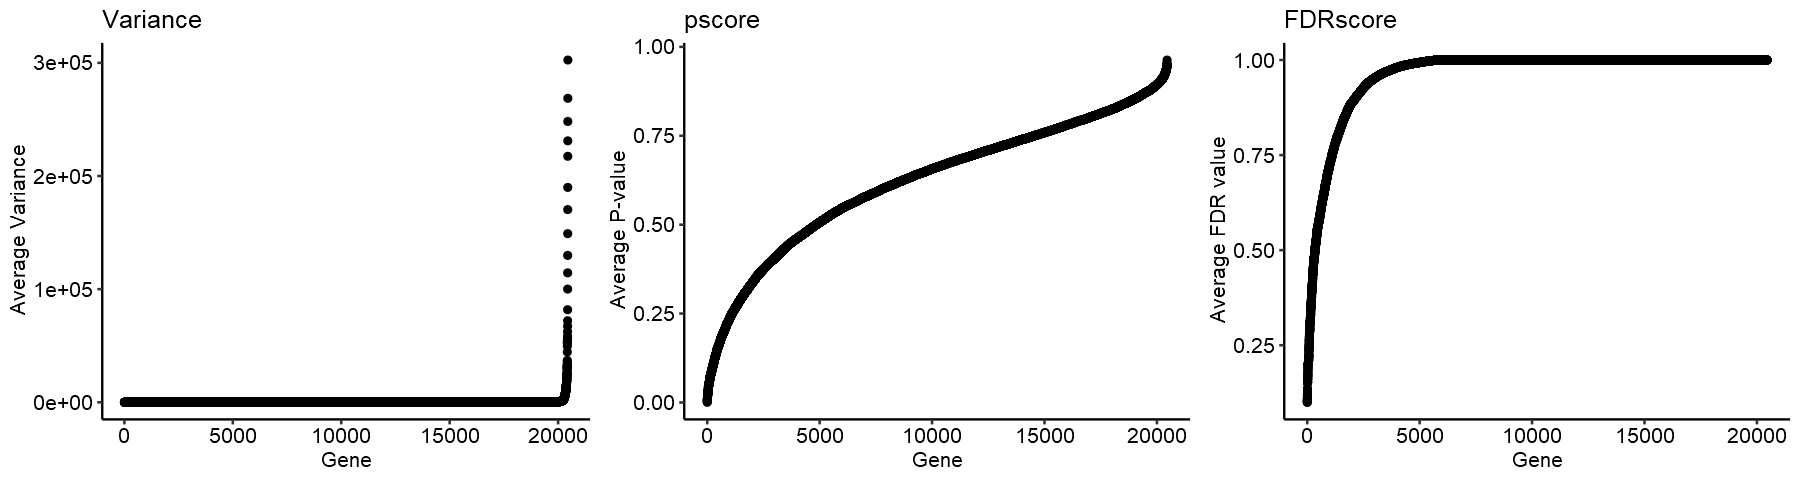

In [6]:
options(repr.plot.width=15, repr.plot.height=4)
p1<- ggplot(var, aes((1:nrow(var)), var_ave))+geom_point()+theme_pubr()+ggtitle("Variance")+ylab("Average Variance")+xlab("Gene")
p2 <- ggplot(pscore, aes((1:nrow(pscore)), V1))+geom_point()+theme_pubr()+ggtitle("pscore")+ylab("Average P-value")+xlab("Gene")
p3 <- ggplot(FDRscore, aes((1:nrow(FDRscore)), V1))+geom_point()+theme_pubr()+ggtitle("FDRscore")+ylab("Average FDR value")+xlab("Gene")
grid.arrange(p1, p2, p3, nrow = 1)

This information indicates that the FDR score may be the best strategy for identifying genes that are differentially regulated across all time points. Therefore, the average FDR will be used to classify genes according to if they are PS/OS responsive or shear responsive regardless of flow.

In [7]:
dt$FDRscore_shear <- probabilityScoreR(DT= dt, column_names = "LF_FDR")
dt$FDRscore_PSOS <- probabilityScoreR(DT= dt, column_names = "OS[0-9]+_FDR")
#### Annotate shear responsive genes #### 
dt$shear_responsive <- "NA"
dt[(dt$`OS24-LF_logFC` > 0 & dt$`PS24-LF_logFC` > 0) & (dt$FDRscore_shear < 0.9) & (dt$`PS24-OS24_FDR` > 0.05) | 
      (dt$`OS24-LF_logFC` < 0 & dt$`PS24-LF_logFC` < 0) & (dt$FDRscore_shear < 0.9) & (dt$`PS24-OS24_FDR` > 0.05),]$shear_responsive <- "pattern_independent"
#### Annotate PSOS responsive genes ####
dt$PSOS_responsive <- "NA"
dt[dt$FDRscore_PSOS < 0.86,]$PSOS_responsive <- "PSOS" # threshold 0.8
dt <- dt[order(dt$FDRscore_shear),]
writab(DT=dt, fname="./results/1 shear_scored_flow_responsive_annotated.xls")

#### Generate a line graph of the raw read values of the top shear responsive gene and the top PSOS responsive gene

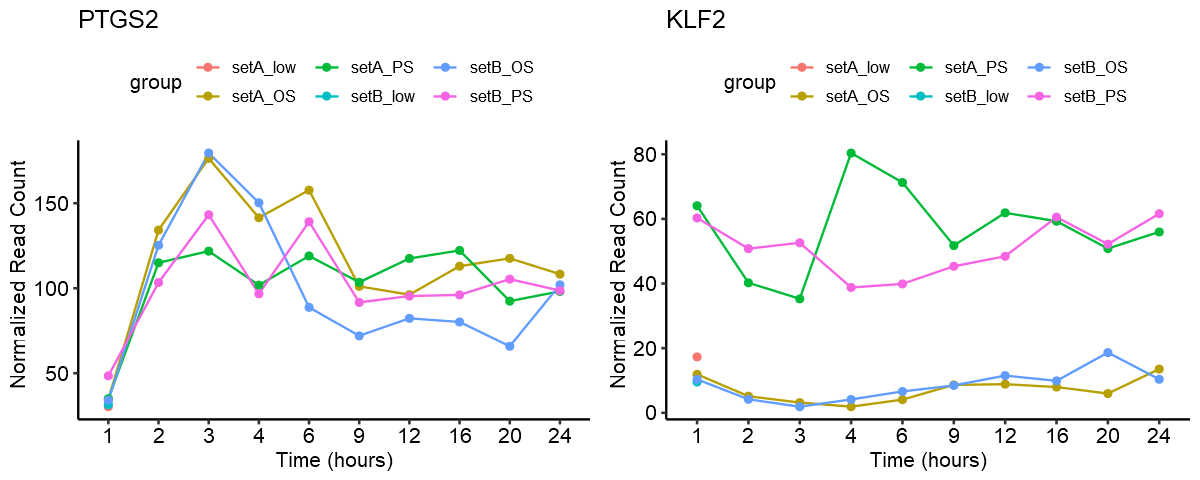

In [8]:
options(repr.plot.width=10, repr.plot.height=4)
p1 <- grapher(dt[1,c(1,93:134), with = FALSE])
p2 <- grapher(dt[order(dt$FDRscore_PSOS),][1,c(1,93:134), with = FALSE])
grid.arrange(p1, p2, nrow = 1)

#### Generate a line graphs of the raw read values of the shear responsive PSOS responsive genes

In [9]:
#### plot all genes according to ranking in a loop ####
dir.create("./results/1_shear_responsive"); dir.create("./results/1_PSOS_responsive"); dir.create("./results/1_shear_and_PSOS_responsive")
lineGraph_loopR(DataTable = dt[(shear_responsive == "pattern_independent") & (!PSOS_responsive == "PSOS"),], directory = "./results/1_shear_responsive/", columns = c(1,93:134))
lineGraph_loopR(DataTable = dt[order(dt$FDRscore_PSOS),][(!shear_responsive == "pattern_independent") & (PSOS_responsive == "PSOS"),], directory = "./results/1_PSOS_responsive/", columns = c(1,93:134))
lineGraph_loopR(DataTable = dt[(shear_responsive == "pattern_independent") & (PSOS_responsive == "PSOS"),], directory = "./results/1_shear_and_PSOS_responsive/", columns = c(1,93:134))

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


# Section II Explore which human proteins that interact with SARS-CoV-2 proteins are shear or PSOS responsive.

The SARS-CoV-2 gene interactions were downloaded from: http://geneontology.org/covid-19.html

#### Annotate database of shear and PSOS responsive genes with the SARS-CoV-2 interacting proteins

In [10]:
binding <- fread(coviddb)
entry <- c("ACE2", "TMPRSS2") #### Human proteins involved in viral entry ####
#### Annotate according to which genes are COVID-19 binding proteins ####
dt$COVID_interaction <- "NA"
dt[(toupper(dt$GeneName) %in% toupper(c(binding$PreyGene, entry))),]$COVID_interaction <- "COVID_interactor"
final_covid <- dt
#### polish genes that were called incorrectly ####
shear_rm <- c("PPT1", "CHMP2A", "PSMD8", "ITGB1", "MAP7D1", "NUFB9") #### Genes to remove from shear dataset
psos_rm <- c("EIF4H", "SLC44A2") #### Genes to remove from psos dataset
psos_to_shear <- c("GDF15") #### Genes to move freom psos dataset to shear dataset # "FBLN5",
#### remove genes ####
final_covid[(final_covid$GeneName %in% shear_rm),]$shear_responsive <- "NA"
final_covid[(final_covid$GeneName %in% psos_rm),]$PSOS_responsive <- "NA"
#### move genes to proper datatable ####
final_covid[final_covid$GeneName == psos_to_shear[1] | final_covid$GeneName == psos_to_shear[2],]$PSOS_responsive <- "NA"
final_covid[final_covid$GeneName == psos_to_shear[1] | final_covid$GeneName == psos_to_shear[2],]$shear_responsive <- "pattern_independent"
writab(DT=final_covid, fname="./results/2 COVID annotated data table.xls")

#### Subset out genes that are shear or PSOS responsive and interact with a SARS-CoV-2 protein

In [11]:
#### pull out COVID-19 interacting proteins ####
covid <- final_covid[final_covid$COVID_interaction == "COVID_interactor",]
#### separate into PSOS or shear responsive ####
covid_shear <- covid[covid$shear_responsive == "pattern_independent",]
covid_psos <- covid[covid$PSOS_responsive == "PSOS",]
#### remove duplications ####
covid_sheardup <-covid_shear[covid_shear[, .I[which.min(`FDRscore_shear`)], by=GeneName]$V1]
covid_psosdup <-covid_psos[covid_psos[, .I[which.min(`FDRscore_PSOS`)], by=GeneName]$V1]
#### overlapping genes ####
intersect(covid_sheardup$GeneName, covid_psosdup$GeneName)
#covid[covid$GeneName == intersect(covid_sheardup$GeneName, covid_psosdup$GeneName),]
covid <- rbind(covid_sheardup, covid_psosdup)
#### annotate with the name of the protein each gene interacts with ####
bindingsub <- binding[,(colnames(binding) %in% c("Bait", "PreyGene", "Uniprot Function", "Uniprot Function in Disease")), with = FALSE]
colnames(bindingsub)[2] <- "GeneName"
covid <- merge(covid, bindingsub, by = "GeneName")
writab(DT=covid, fname="./results/3 final COVID only data table.xls")

character(0)

#### Generate a line graphs of the raw read values of the SARS-CoV-2 interacting proteins

In [12]:
#### plot all finalized genes ####
dir.create("./results/2_COVID_shear_responsive"); dir.create("./results/2_COVID_PSOS_responsive")
lineGraph_loopR(DataTable = covid[shear_responsive == "pattern_independent",], directory = "./results/2_COVID_shear_responsive/", columns = c(1,93:134), resolution = "low")
lineGraph_loopR(DataTable = covid[PSOS_responsive == "PSOS",], directory = "./results/2_COVID_PSOS_responsive/", c(1,93:134), resolution = "low")

  |======================================================================| 100%
  |======================================================================| 100%


#### Heatmap of the fold changes of the flow PSOS and flow independent genes that interact with SARS-CoV-2 proteins.

png 
  2

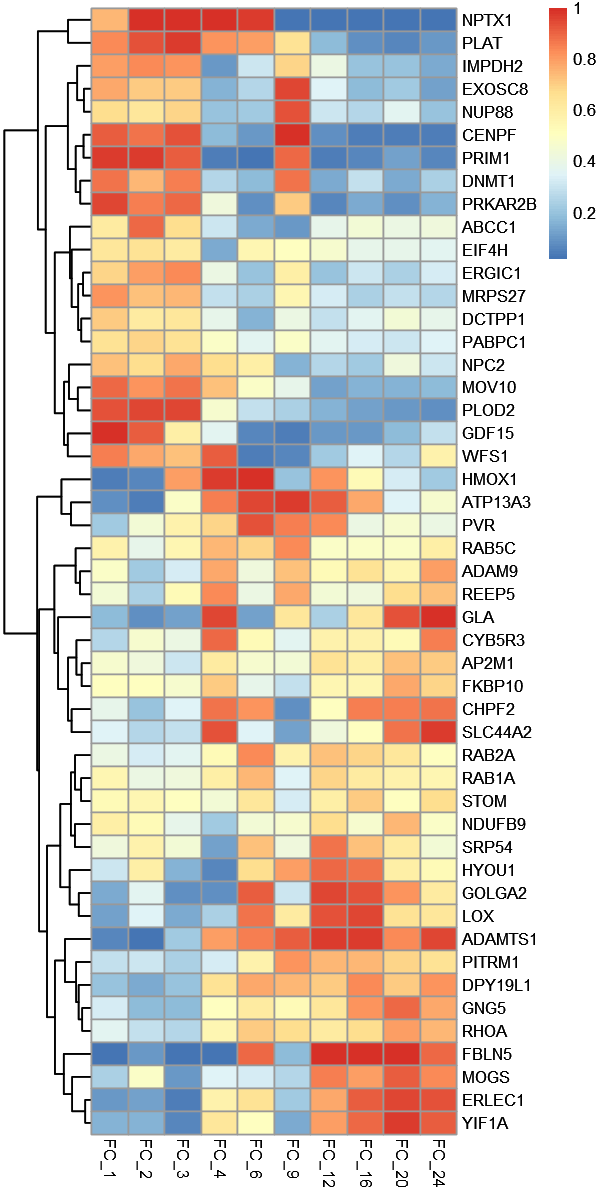

In [13]:
options(repr.plot.width=5, repr.plot.height=10)
Data <- covid[,c(1,93:134), with = FALSE]
DATA_matrix <- heatmapNormalize(Data)
p <- pheatmap(percentize(DATA_matrix), cluster_row = TRUE, cluster_cols = FALSE, show_rownames = TRUE);p
tiff(file = "./results/4 shear heatmap normalized.tiff", width = 2000, height = 5300, units = "px", res = 400);p;dev.off()

#### Generate a venn diagram of the overlap between the POSOS responsive genes, the shear responsive genes, and the SARS-CoV-2 interacting proteins 

In [14]:
psosven <- final_covid[final_covid$PSOS_responsive == "PSOS",]$GeneName; psosven <- psosven[!duplicated(psosven)]
shearven <- final_covid[final_covid$shear_responsive == "pattern_independent",]$GeneName; shearven <- shearven[!duplicated(shearven)]
covidven <- final_covid[final_covid$COVID_interaction == "COVID_interactor",]$GeneName; covidven <- covidven[!duplicated(covidven)]
#### Make the plot
catnames <- c("PSOS responsive", "Shear responsive", "SARS CoV 2 interaction")
venn.diagram(
  x = list(psosven, shearven, covidven),
  category.names = catnames,
  filename = './results/5_venn_diagramm.png',
  output=TRUE,
  imagetype="png" ,
  height = 480 , 
  width = 480 , 
  resolution = 300,
  compression = "lzw",
  lwd = 1,
  col=c("#440154ff", '#21908dff', '#fde725ff'),
  fill = c(alpha("#440154ff",0.3), alpha('#21908dff',0.3), alpha('#fde725ff',0.3)),
  cex = 0.5,
  fontfamily = "sans",
  cat.cex = 0.3,
  cat.default.pos = "outer",
  cat.pos = c(-27, 27, 135),
  cat.dist = c(0.055, 0.055, 0.085),
  cat.fontfamily = "sans",
  cat.col = c("#440154ff", '#21908dff', '#fde725ff'),
  rotation = 1
)

[1] 1

#### Analyse the gene ontology enrichment of the SARS-CoV-2 interacting proteins

In [15]:
go <- BioMartR(value = covid$GeneName, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("wikigene_name", "wikigene_description", "go_id", "name_1006", "definition_1006"),
               filter_by = 'wikigene_name')
head(go, 1)
writab(DT=go, fname="./gene_ontology/1 GO BioMart NCBI annotations.xls")

wikigene_name,wikigene_description,go_id,name_1006,definition_1006
<chr>,<chr>,<chr>,<chr>,<chr>
ABCC1,ATP binding cassette subfamily C member 1,GO:0016021,integral component of membrane,The component of a membrane consisting of the gene products and protein complexes having at least some part of their peptide sequence embedded in the hydrophobic region of the membrane.


#### Obtain go ID frequency counts

In [16]:
gofreq <- freqsdt("go", "go_id")
# annotate with GO name
dict <- go[!duplicated(go$go_id),][,3:4, with = FALSE]
goannot <- merge(gofreq, dict, by = "go_id"); goannot <- goannot[order(goannot$count, decreasing = TRUE),]
writab(DT=goannot, fname="./results/6 GO enrichment.xls")
goannot <- fread("./results/6 GO enrichment.xls")

#### Enrich for COVID-19 related terms

In [17]:
viralprocess <- c("membrane", "extracellular exosome", "endoplasmic reticulum", 
                  "integral component of membrane", "RNA binding", "Golgi apparatus", "viral process",
                  "protein transport", "Golgi membrane", "endoplasmic reticulum to Golgi vesicle-mediated transport",
                  "vesicle-mediated transport", "Golgi organization", "COPII-coated ER to Golgi transport vesicle")
outcome <- c("mitochondrion", "focal adhesion", "cell adhesion", "cell cycle", "positive regulation of I-kappaB kinase/NF-kappaB signaling",
             "Coagulation", "inflammatory", "thrombin")
viralradar <- goannot[(goannot$name_1006 %in% viralprocess),]
outcomeradar <- goannot[(goannot$name_1006 %in% outcome),]
#### clean GO names
viralradar[grep("COPII", viralradar$name_1006),]$name_1006 <- "ER to Golgi transport vesicle"
viralradar[grep("to Golgi vesicle", viralradar$name_1006),]$name_1006 <- "ER to Golgi transport"
viralradar[grep("component of membrane", viralradar$name_1006),]$name_1006 <- "membrane component"
outcomeradar[grep("positive regulation of I", outcomeradar$name_1006),]$name_1006 <- "activation of NFkB"

In [18]:
options(repr.plot.width=7, repr.plot.height=7)
#### Generate plot of cell functions important for viral replication
radar <- viralradar
data <- as.data.frame(matrix(radar$count , ncol=length(radar$go_id)))
colnames(data) <- radar$name_1006
data <- rbind(rep(radar[which.max(radar$count),]$count,nrow(radar)) , rep(0,nrow(radar)) , data)
radar[which.max(radar$count),]$count
tiff(file = "./results/7 cell function go term radar.tiff", width = 750, height = 700, units = "px", res = 100)
radarchart(data, axistype=1 ,
           #custom polygon
           pcol=rgb(0.2,0.5,0.5,0.9) , pfcol=rgb(0.2,0.5,0.5,0.5) , plwd=4 ,
           #custom the grid
           cglcol="grey", cglty=1, axislabcol="grey", caxislabels=seq(0,40,(40/5)), cglwd=0.8,
           #custom labels
           vlcex=0.8)
dev.off()

[1] 31

png 
  2

In [19]:
options(repr.plot.width=7, repr.plot.height=7)
#### Generate plot of cell functions that are related to COVID-19 co-morbidities
radar <- outcomeradar
data <- as.data.frame(matrix(radar$count , ncol=length(radar$go_id)))
colnames(data) <- radar$name_1006
data <- rbind(rep(radar[which.max(radar$count),]$count,nrow(radar)) , rep(0,nrow(radar)) , data)
radar[which.max(radar$count),]$count
tiff(file = "./results/8 cell phenotype go term radar.tiff", width = 750, height = 700, units = "px", res = 100)
radarchart(data, axistype=1 ,
           #custom polygon
           pcol=rgb(0.2,0.5,0.5,0.9) , pfcol=rgb(0.2,0.5,0.5,0.5) , plwd=4 ,
           #custom the grid
           cglcol="grey", cglty=1, axislabcol="grey", caxislabels=seq(0,10,(10/5)), cglwd=0.8,
           #custom labels
           vlcex=0.8)
dev.off()

[1] 6

png 
  2

#### Expand the network to SARS-CoV-2 indirect binding partners. String and Cytoscape were used to infer proteins that are likely to be effected by the primary protein-protein interaction.

In [20]:
cyto <- fread(cytofile);cyto <- cyto[!grep("SARS", Node),]
#### pull out COVID-19 interacting proteins ####
covidcyto <- final_covid[(final_covid$GeneName %in% cyto$interact),]
#### separate into PSOS or shear responsive ####
covidcyto_shear <- covidcyto[covidcyto$shear_responsive == "pattern_independent",]
covidcyto_psos <- covidcyto[covidcyto$PSOS_responsive == "PSOS",]
#### remove duplications ####
covidcyto_sheardup <-covidcyto_shear[covidcyto_shear[, .I[which.min(`FDRscore_shear`)], by=GeneName]$V1]
covidcyto_psosdup <-covidcyto_psos[covidcyto_psos[, .I[which.min(`FDRscore_PSOS`)], by=GeneName]$V1]
#### polish genes that were called incorrectly
shear_rm <- c("TRAPPC1", "C19orf48", "SYVN1", "ARHGDIA") #### Genes to remove from shear dataset
psos_rm <- c("NQO1", "DAD1") #### Genes to remove from psos dataset# FBLN5 # 
#### remove genes ####
covidcyto_sheardup <- covidcyto_sheardup[!(covidcyto_sheardup$GeneName %in% shear_rm),]
covidcyto_psosdup <- covidcyto_psosdup[!(covidcyto_psosdup$GeneName %in% psos_rm),]
#### overlapping genes ####
intersect(covidcyto_sheardup$GeneName, covidcyto_psosdup$GeneName)
covid_cyto <- rbind(covidcyto_sheardup, covidcyto_psosdup)
covid_cyto[GeneName == "DAD1"]$PSOS_responsive <- "NA"
writab(DT=covid_cyto, fname="./results/9 COVID cytoscape interest genes.xls")

character(0)

#### Generate a line graphs of the raw read values of the SARS-CoV-2 indirect interacting shear responsive and PSOS responsive genes

In [21]:
#### plot all finalized genes ####
dir.create("./results/3_COVID_cytoscape_shear_responsive");dir.create("./results/3_COVID_cytoscape_PSOS")
lineGraph_loopR(DataTable = covid_cyto[shear_responsive == "pattern_independent",], directory = "./results/3_COVID_cytoscape_shear_responsive/", columns = c(1,93:134), resolution = "low")
lineGraph_loopR(DataTable = covid_cyto[PSOS_responsive == "PSOS",], directory = "./results/3_COVID_cytoscape_PSOS/", c(1,93:134), resolution = "low")

  |======================================================================| 100%
  |======================================================================| 100%


#### Create a heatmap illustrating the fold changes of genes that respond to flow (PSOS or shear) and are also part of the SARS-CoV-2 interacting network.

png 
  2

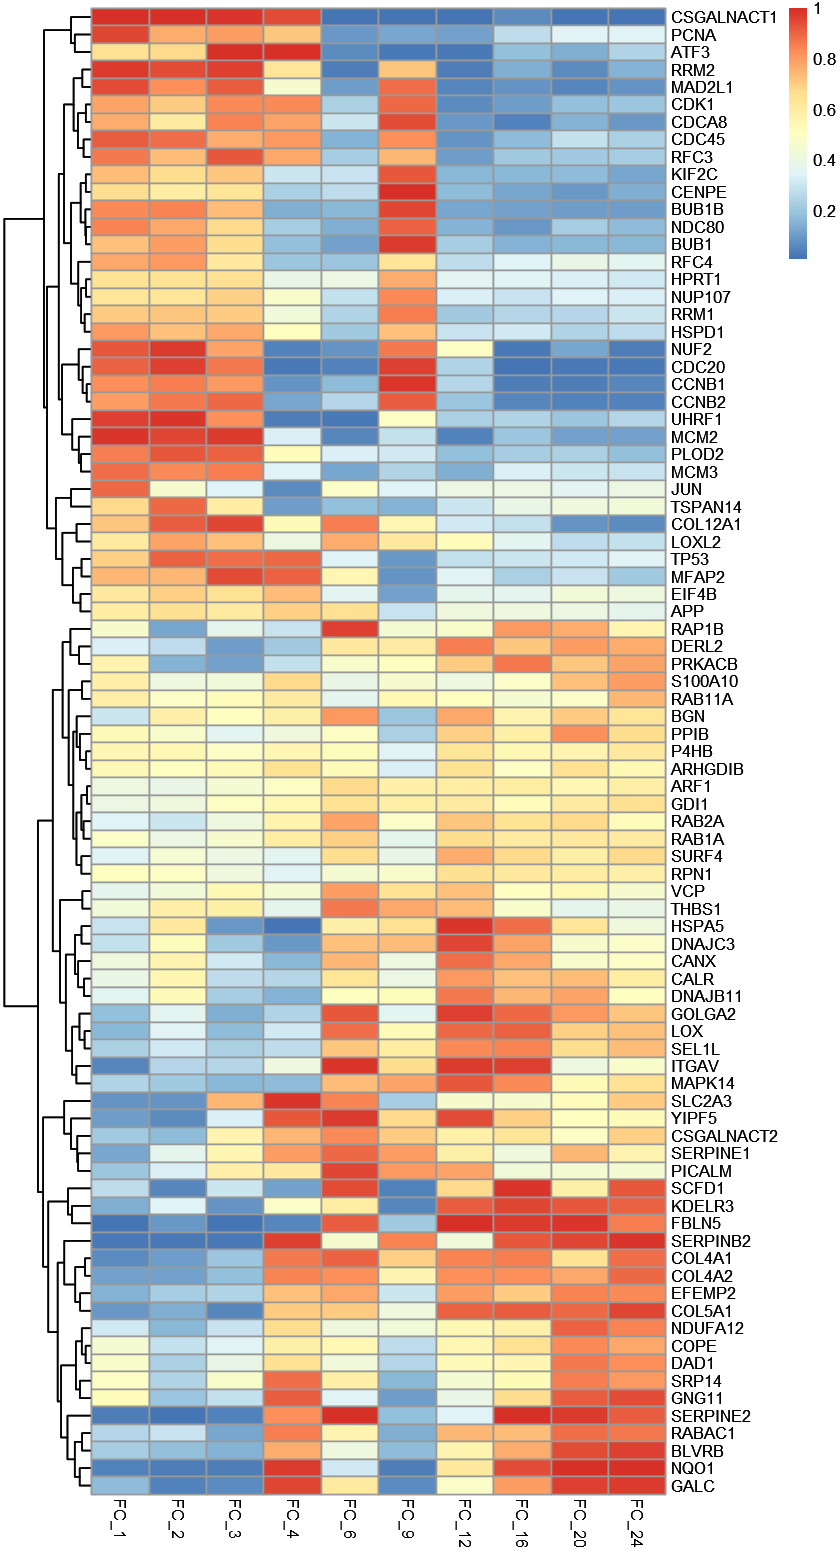

In [22]:
options(repr.plot.width=7, repr.plot.height=13)
Data <- covid_cyto[,c(1,93:134), with = FALSE]
DATA_matrix <- heatmapNormalize(Data)
p <- pheatmap(percentize(DATA_matrix), cluster_row = TRUE, cluster_cols = FALSE, show_rownames = TRUE);p
tiff(file = "./results/10 COVID cytoscape heatmap normalized.tiff", width = 2000, height = 5300, units = "px", res = 400);p;dev.off()

#### Obtain gene ontology information for the extended SARS-CoV-2 interacting network

In [23]:
go <- BioMartR(value = covid_cyto, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("wikigene_name", "wikigene_description", "go_id", "name_1006", "definition_1006"),
               filter_by = 'wikigene_name')
head(go, 1)
writab(DT=go, fname="./gene_ontology/2 GO BioMart cytoscape annotations.xls")

wikigene_name,wikigene_description,go_id,name_1006,definition_1006
<chr>,<chr>,<chr>,<chr>,<chr>
APP,amyloid beta precursor protein,GO:0016021,integral component of membrane,The component of a membrane consisting of the gene products and protein complexes having at least some part of their peptide sequence embedded in the hydrophobic region of the membrane.


# Explore the mechanistic basis for how the SARS-CoV-2 interacting network may be differentially regulated and predict kinases that can regulate their activity.

### Identify transcription factor binding sites in the promoters of genes in the SARS-CoV-2 network

#### Compile SARS-CoV-2 interacting proteins and the cytoscape expanded network into a single data.table

In [24]:
DIFsub <- data.table(c(covid$GeneName, covid_cyto$GeneName)) %>% setnames("V1", "wikigene_name")
DIFsub$wikigene_name <- toupper(DIFsub$wikigene_name)
ID2 <- toupper(DIFsub$wikigene_name)

#### Load mRNA sequences for the genes in the SARS-CoV-2 network

In [25]:
# Load the sequence compiled mRNA database
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/cDNA_transcriptome/2016-3-6 cDNA transcriptomes")
mRNAs <- fread("3 Annotated species mRNA compilation.xls"); setwd(homedir)
mRNAs$external_gene_name <- toupper(mRNAs$external_gene_name)
# Clean data.table
CHR_Labels <- c(1:21, "X", "Y")
TRANS_CHR <- mRNAs[(mRNAs$external_gene_name %in% ID2),] # subset out mRNAs of interest
TRANS_CHR <- TRANS_CHR[(TRANS_CHR$chromosome_name %in% CHR_Labels),] # remove erroneous chromosome labels
TRANS_CHR <- ChromLabel(TRANS_CHR) # relabel chromosome names
TRANS_CHR[1:2,c(1,3:10), with = FALSE]

ensembl_transcript_id,Species_File,Scientific_Name,Common_Name,external_gene_name,transcription_start_site,transcript_start,transcript_end,chromosome_name
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
ENSACAT00000000120,Anolis_carolinensis.AnoCar2.0.cdna.all.fa.gz,Anolis_carolinensis,Lizard,RRM2,148019236,148001345,148019236,chr1
ENSACAT00000001871,Anolis_carolinensis.AnoCar2.0.cdna.all.fa.gz,Anolis_carolinensis,Lizard,DNAJC3,85358907,85358907,85414968,chr3


#### Obtain and clean promoter sequences for genes in the SARS-CoV-2 network

In [26]:
# Load available genomes
ToLoad <- c("Hsapiens.UCSC.hg38","Mmusculus.UCSC.mm10","Rnorvegicus.UCSC.rn6","Btaurus.UCSC.bosTau8","Cfamiliaris.UCSC.canFam3", 
            "Ggallus.UCSC.galGal4","Mmulatta.UCSC.rheMac3","Ptroglodytes.UCSC.panTro3","Sscrofa.UCSC.susScr3")
GenomeLoader(ToLoad)
# return the promoter sequences for the identified transcripts from each Species
genome <- c("Hsapiens.UCSC.hg38","Mmusculus.UCSC.mm10","Rnorvegicus.UCSC.rn6","Btaurus.UCSC.bosTau8", "Cfamiliaris.UCSC.canFam3"
            ,"Ggallus.UCSC.galGal4","Mmulatta.UCSC.rheMac3","Ptroglodytes.UCSC.panTro3","Sscrofa.UCSC.susScr3")
PROMTrans <- ChromosomeSeqCompileR(DT = TRANS_CHR, Spec = genome, distance = 2000)
# Remove sequences that contain a large number of N's 
setnames(PROMTrans, c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Genome_Sequence"),
         c("ensembl_transcript_id", "mRNA_Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Sequence"))
PROMTrans <- SequenceSiftR(PROMTrans, Percent = 0.50, output = "return_remove")
# Sort out Splice Variants so that the longest transcript of each protein is represented only once in each species
setnames(PROMTrans, c("ensembl_transcript_id", "mRNA_Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Sequence", "Percent_N"),
         c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Genome_Sequence", "Percent_N"))
PROMTrans <- VariantSort(PROMTrans, variant = "MAX")
PROMTrans[1:2,c(1, 3:10, 12:13), with = FALSE]

  |======================================================================| 100%
  |======================================================================| 100%


ensembl_transcript_id,Species_File,Scientific_Name,Common_Name,external_gene_name,transcription_start_site,transcript_start,transcript_end,chromosome_name,Percent_N,Length
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>
ENST00000035307,Homo_sapiens.GRCh38.cdna.all.fa.gz,Homo_sapiens,Human,CHPF2,151232499,151232499,151238827,chr7,0,3978
ENST00000486749,Homo_sapiens.GRCh38.cdna.all.fa.gz,Homo_sapiens,Human,SLC2A3,7936167,7919231,7936167,chr12,0,4414


#### Identify transcription factor binding sites in the promoter sequences for genes in the SARS-CoV-2 network

In [27]:
# Load and annotate the TX_factor data table
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/scripts/transcription factor consensus sequence")
TXDT <- fread("2019-3-22 TX factor data table for R BG.csv", header = TRUE); setwd(homedir)
TXDT <- TXDT[,.(prot, `MotifMap Degenerate consensus sequence`)]
TXDT$prot <- toupper(TXDT$prot)
TXDT$Consensus_Sequence_Medium <- IUPAC_Boolean(TXDT$`MotifMap Degenerate consensus sequence`, stringency = "medium")
setnames(TXDT, c("prot", "MotifMap Degenerate consensus sequence", "Consensus_Sequence_Medium"),
         c("Targeting_Factor", "MotifMap Degenerate consensus sequence", "Consensus_Sequence"))
head(TXDT, 2)
# Perform the transcription factor binding site matches
setnames(PROMTrans, c("ensembl_transcript_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "external_gene_name", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Genome_Sequence", "Percent_N", "Length"),
         c("ensembl_transcript_id", "mRNA_Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "transcription_start_site", "transcript_start", "transcript_end", "chromosome_name", "Sequence", "Percent_N", "Length"))
TX_TOT_Species <- TFpredict(Target = PROMTrans, Targeting_Factor_DT = TXDT, type = "multiple_species")

Targeting_Factor,MotifMap Degenerate consensus sequence,Consensus_Sequence
<chr>,<chr>,<chr>
AHR,SYYCNRNSTNGCGTGNSW,(G|C)(C|T)(C|T)C.(A|G).(G|C)T.GCGTG.(G|C)(A|T)
AHR,BKNGCGTGHNN,.(G|T).GCGTG...


  |======================================================================| 100%


#### Score, set minimum species conservation cutoff, and count the number of transcription factor binding sites for each promoter sequence

In [28]:
#### Annotate the raw transcription factor hits DT with the IUPAC consensus score
DT25 <- TX_TOT_Species[,c(1:7, 9:12), with = FALSE]
IUPAC <- DT25$`MotifMap Degenerate consensus sequence`
DT25$Score <- IUPAC_ScoreR(IUPAC, stringency = "medium")
#### Retain only transcription factor promoter association conservation between HMR at each promoter 
DT25 <- SpeciesTFCons(DT = DT25,Spec = c("Human", "Mouse", "Rat"), provide = "TF_Target")
writab(DT=DT25, fname="./results/11 HMR Raw Transcription factor hits.xls")
#### Determine the number of times each transcription factor consensus sequence is present for each promoter in human 
TX_ABUN <- TFRankR(DT = DT25, sortBy = "abundance", dec = TRUE); TX_ABUN <- TX_ABUN[TX_ABUN$Species == "Human",]; head(TX_ABUN,3)
writab(DT=TX_ABUN, fname="./results/12 TX number of consensus sequences Human.xls")

  |======================================================================| 100%


Number_Hits,Targeting_Factor,gene_symbol,Species
<int>,<chr>,<chr>,<chr>
162,BMI1,NPTX1,Human
126,BMI1,GDI1,Human
120,BMI1,ARF1,Human


### Assess the number of KLF2 and SREBP2 binding sites in the promoters of genes regulated by shear and PSOS.

png 
  2

[1] "ATP13A3"    "NUP107"     "CSGALNACT2" "RFC3"       "DAD1"      
[6] "KIF2C"      "MFAP2"

character(0)

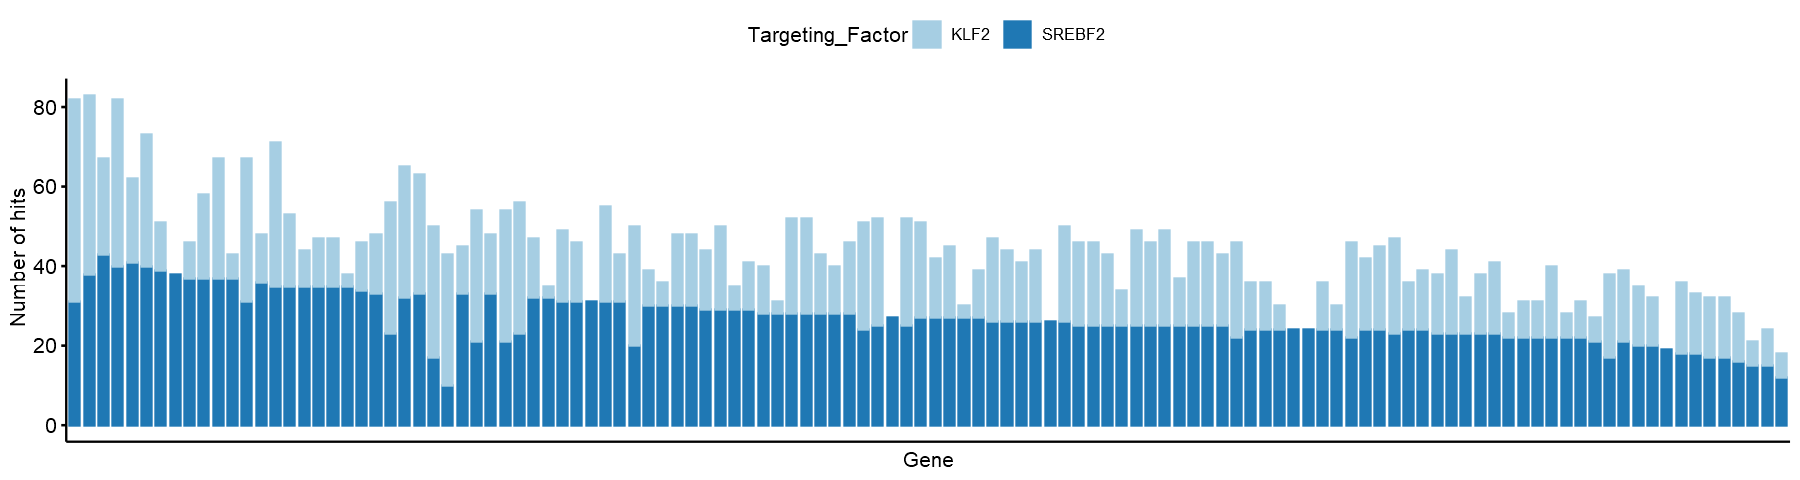

In [29]:
options(repr.plot.width=15, repr.plot.height=4)
KLF <- TX_ABUN[Targeting_Factor == "SREBF2" | Targeting_Factor == "KLF2",]
g1 <- ggbarplot(KLF, "gene_symbol", "Number_Hits",
          fill = "Targeting_Factor", color = "Targeting_Factor", palette = "Paired")+
    theme(axis.text.x=element_blank(),axis.ticks.x=element_blank())+
    xlab("Gene")+ylab("Number of hits");g1
tiff(file = "./results/13 shear tx factor binding sites.tiff", width = 1000, height = 500, units = "px", res = 100);g1;dev.off()
setdiff(KLF[KLF$Targeting_Factor == "SREBF2",]$gene_symbol, KLF[KLF$Targeting_Factor == "KLF2",]$gene_symbol)
setdiff(KLF[KLF$Targeting_Factor == "KLF2",]$gene_symbol, KLF[KLF$Targeting_Factor == "SREBF2",]$gene_symbol)

#### Identify PSOS or shear regulated transcription factors. 

In [30]:
# Annotate the complete data table that is annotated with Shear or PSOS responsiveness, and which proteins interact 
# with SARS-CoV-2 proteins with which genes are also a transcription factor
final_covid$TXfactor <- "NA"
keyTX <- TX_ABUN[!duplicated(TX_ABUN$Targeting_Factor),]$Targeting_Factor
final_covid[(final_covid$GeneName %in% keyTX),]$TXfactor <- "TXfactor"
#### separate into PSOS or shear responsive ####
independent <- final_covid[final_covid$shear_responsive == "pattern_independent" & final_covid$TXfactor == "TXfactor",]
psos <- final_covid[final_covid$PSOS_responsive == "PSOS" & final_covid$TXfactor == "TXfactor",]
#### remove duplications ####
independentdup <-independent[independent[, .I[which.min(`FDRscore_shear`)], by=GeneName]$V1]
psosdup <-psos[psos[, .I[which.min(`FDRscore_PSOS`)], by=GeneName]$V1]
#### overlapping genes ####
intersect(independentdup$GeneName, psosdup$GeneName)
interestTFs <- rbind(independentdup, psosdup)
# polish genes that were called incorrectly ####
shear_rm <- c("NCL") # Genes to remove from shear dataset
shear_to_psos <- c("EPAS1") # Genes to move freom psos dataset to shear dataset
#### remove genes ####
interestTFs[(interestTFs$GeneName %in% shear_rm),]$shear_responsive <- "NA"
#### move genes to proper datatable ####
interestTFs[interestTFs$GeneName == shear_to_psos[1],]$PSOS_responsive <- "PSOS"
interestTFs[interestTFs$GeneName == shear_to_psos[1],]$shear_responsive <- "NA"
writab(DT=interestTFs, fname="./results/14 covid interest transcription factors.xls")

[1] "EPAS1"

#### Generate a line graphs of the raw read values of the shear responsive PSOS responsive genes

In [31]:
#### plot all identified genes ####
dir.create("./results/4_PSOS_txfactor");dir.create("./results/4_flow_independent_txfactor")
lineGraph_loopR(DataTable = interestTFs[PSOS_responsive == "PSOS",], directory = "./results/4_PSOS_txfactor/", columns = c(1,93:134))
lineGraph_loopR(DataTable = interestTFs[shear_responsive == "pattern_independent",], directory = "./results/4_flow_independent_txfactor/", columns = c(1,93:134))

  |======================================================================| 100%
  |======================================================================| 100%


#### Match transcription factors and genes they regulate by their PSOS or shear responsive sharacteristics

In [32]:
#### Separate transcription factors into PSOS or shear responsive #####
shearTX <- interestTFs[shear_responsive == "pattern_independent",]
psosTX <- interestTFs[PSOS_responsive == "PSOS",]
sheartxkey <- shearTX$GeneName
psostxkey <- psosTX$GeneName
#### compile all COVID-19 genes and separate into PSOS or shear responsive 
intersect(covid_cyto$GeneName, covid$GeneName)
compiledcovid <- rbind(covid_cyto, covid[,c(1:139), with = FALSE])
shear <- compiledcovid[compiledcovid$shear_responsive == "pattern_independent",]
psos <- compiledcovid[compiledcovid$PSOS_responsive == "PSOS",]
shearkey <- shear$GeneName
psoskey <- psos$GeneName

[1] "PLOD2"  "RAB2A"  "LOX"    "GOLGA2" "RAB1A"  "FBLN5"

#### Plot PSOS responsive transcription factors that have binding sites in the promoters of PSOS genes. 

png 
  2

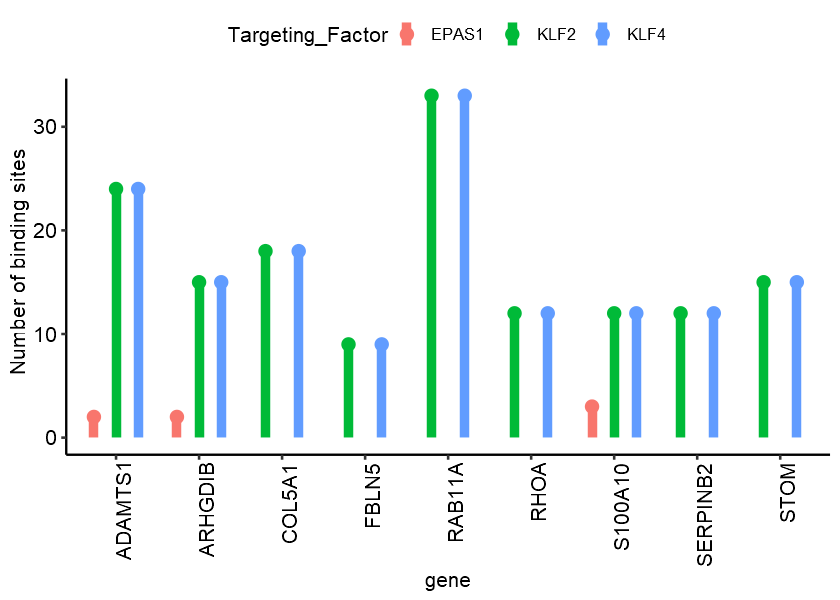

In [33]:
options(repr.plot.width=7, repr.plot.height=5)
hit <- TX_ABUN[(TX_ABUN$Targeting_Factor %in% psostxkey),]; hit <- hit[(hit$gene_symbol %in% psoskey)]
g1 <- ggplot(data=hit, aes(x=gene_symbol, y=Number_Hits, group=Targeting_Factor, colour=Targeting_Factor)) +
  geom_linerange(data=hit, mapping=aes(x=gene_symbol, ymin=0, ymax=Number_Hits), size = 2, position = position_dodge(width = 0.8))+
  geom_point(size = 3, position = position_dodge(width = 0.8)) +
  theme_pubr() +
  ylab("Number of binding sites") +
  xlab("gene") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1));g1
tiff(file = "./results/15 PSOS tx factor binding sites.tiff", width = 500, height = 500, units = "px", res = 100);g1;dev.off()

#### Plot shear responsive transcription factors that have binding sites in the promoters of shear responsive genes. 

png 
  2

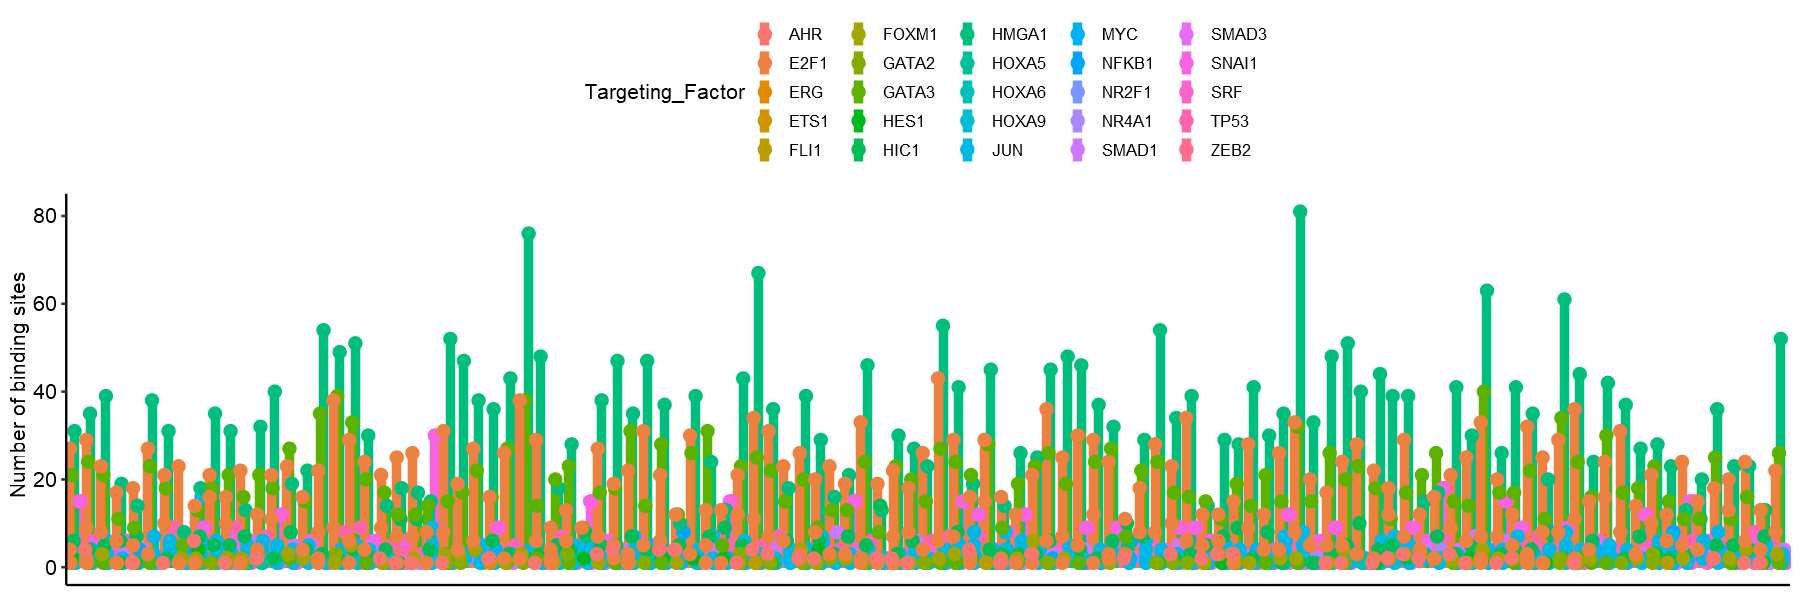

In [34]:
options(repr.plot.width=15, repr.plot.height=5)
hit <- TX_ABUN[(TX_ABUN$Targeting_Factor %in% sheartxkey),]; hit <- hit[(hit$gene_symbol %in% shearkey)]
g1 <- ggplot(data=hit, aes(x=gene_symbol, y=Number_Hits, group=Targeting_Factor, colour=Targeting_Factor)) +
  geom_linerange(data=hit, mapping=aes(x=gene_symbol, ymin=0, ymax=Number_Hits), size = 2, position = position_dodge(width = 0.8))+
  geom_point(size = 3, position = position_dodge(width = 0.8)) +
  theme_pubr() +
  ylab("Number of binding sites") +
  xlab("gene") +
  theme(axis.title.x=element_blank(),axis.text.x=element_blank(),axis.ticks.x=element_blank());g1
tiff(file = "./results/16 shear tx factor binding sites.tiff", width = 1000, height = 500, units = "px", res = 100);g1;dev.off()

#### Plot the level of expression of the 9 PSOS responsive genes in the KLF4 overexpression RNAseq data set.

png 
  2

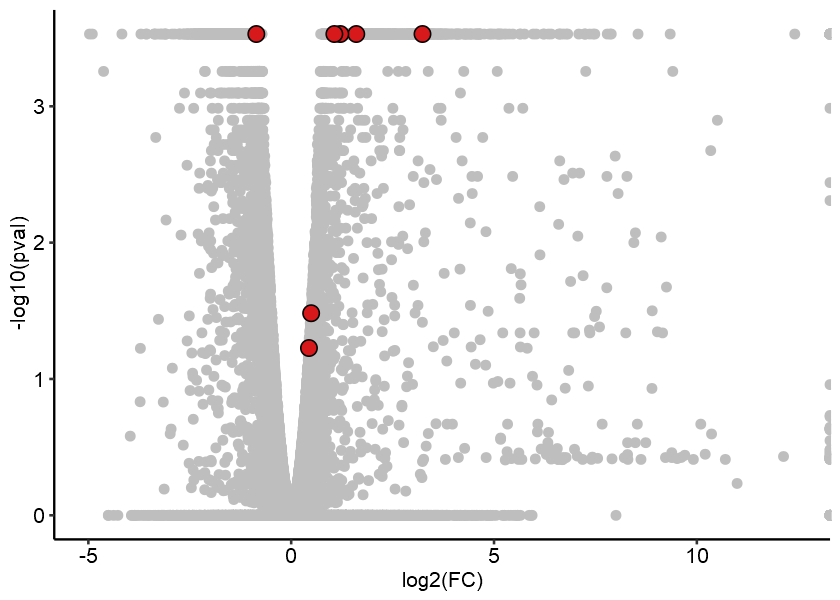

In [35]:
options(repr.plot.width=7, repr.plot.height=5)
DATA <- fread(klf4seq)
DATA$gene <- toupper(DATA$gene)
DATA <- DATA[,c(3,10,13)]
DATA <- DATA[!DATA$`log2(fold_change)` == "#NAME?",]
DATA <- DATA[!DATA$`log2(fold_change)` == "inf",]
DATA$`log2(fold_change)` <- as.numeric(DATA$`log2(fold_change)`)
#### Label all data groups ####
Interactors <- c("ADAMTS1", "ARHGDIB", "COL5A1", "RAB11A",  "S100A10", "SERPINB2", "STOM") # "RHOA", "FBLN5", 
int <- DATA[(DATA$gene %in% Interactors),]
int$group <- "PSOS"
nothing <- DATA[!(DATA$gene %in% Interactors),]
nothing$group <- "All other"
dat <- rbind(int, nothing)
#identical(nrow(DATA), nrow(dat)); nrow(DATA) == nrow(dat)
setnames(dat, colnames(dat), c("gene", "FC", "qval", "group"))
dat$logqval <- -log10(dat$qval) #### Take the -log10 of the q-value
p <- ggplot(dat, aes(x=FC, y=logqval, colour = group)) +
  geom_point(shape = 21, size = 2, colour = "grey", fill = "grey")+
  theme_pubr() +
  labs(x = "log2(FC)", y = "-log10(pval)") +
  geom_point(data = subset(dat, group == 'PSOS'),
             aes(x=FC, y=logqval), shape = 21, size = 4, colour = "black", fill = "#D7191C" );p
tiff(file = "./results/17 KLF4 overexpression.tiff", width = 500, height = 500, units = "px", res = 100);p;dev.off()

### Identify PS/OS H3K27ac CHiPseq peaks in the 9 PS/OS responsive genes

#### Merge Bam files together and create BigWig files

In [37]:
#### merge BAM files
#dir.create("./data/PSOS_H3K27ac/mergebam")
bamfile1 <- "./data/PSOS_H3K27ac/H3K27ac_OS1_R1.fastq.gz.hisat_OS1.bam"                     
bamfile2 <- "./data/PSOS_H3K27ac/H3K27ac_OS2_R1.fastq.gz.hisat_OS2.bam"                        
bamfile3 <- "./data/PSOS_H3K27ac/H3K27ac_PS1_R1.fastq.gz.hisat_PS1.bam"                     
bamfile4 <- "./data/PSOS_H3K27ac/H3K27ac_PS2_R1.fastq.gz.hisat_PS2.bam"                      
mergeBam(files =c(bamfile1, bamfile2), destination= "./results/PSOS_H3K27ac/mergebam/OS.bam")
mergeBam(files =c(bamfile3, bamfile4), destination= "./results/PSOS_H3K27ac/mergebam/PS.bam")
#### Convert Bam files to BigWig files
#dir.create("./data/PSOS_H3K27ac/mergebam/merge_bigwig_files")
bamfile1 <- "./results/PSOS_H3K27ac/mergebam/OS.bam"
bamfile2 <- "./results/PSOS_H3K27ac/mergebam/PS.bam"
BWfile1 <- "./results/PSOS_H3K27ac/mergebam/merge_bigwig_files/OS.bw"
BWfile2 <- "./results/PSOS_H3K27ac/mergebam/merge_bigwig_files/PS.bw"
alignment <- readGAlignments(bamfile1); reads_coverage <- coverage(alignment); export.bw(reads_coverage, con = BWfile1)
alignment <- readGAlignments(bamfile2); reads_coverage <- coverage(alignment); export.bw(reads_coverage, con = BWfile2)

#### Obtain transcription start sites/chromosome locations 

In [38]:
name <- c("ADAMTS1", "RHOA", "STOM", "SERPINB2", "FBLN5", "COL5A1", "S100A10", "ARHGDIB", "RAB11A")
go <- BioMartR(value = name, 
               mart = "ENSEMBL_MART_ENSEMBL", 
               species = "hsapiens_gene_ensembl", 
               attribute = c("wikigene_name",  "transcription_start_site", "chromosome_name"),
               filter_by = 'wikigene_name')
head(go, 1)
writab(DT=go, fname="./gene_ontology/3 BioMart PSOS transcript information.xls")

wikigene_name,transcription_start_site,chromosome_name
<chr>,<int>,<int>
ADAMTS1,26845409,21


#### Make graphs of the level of H3K27ac flanking the Transcription start site for each PSOS responsive gene 

png 
  2

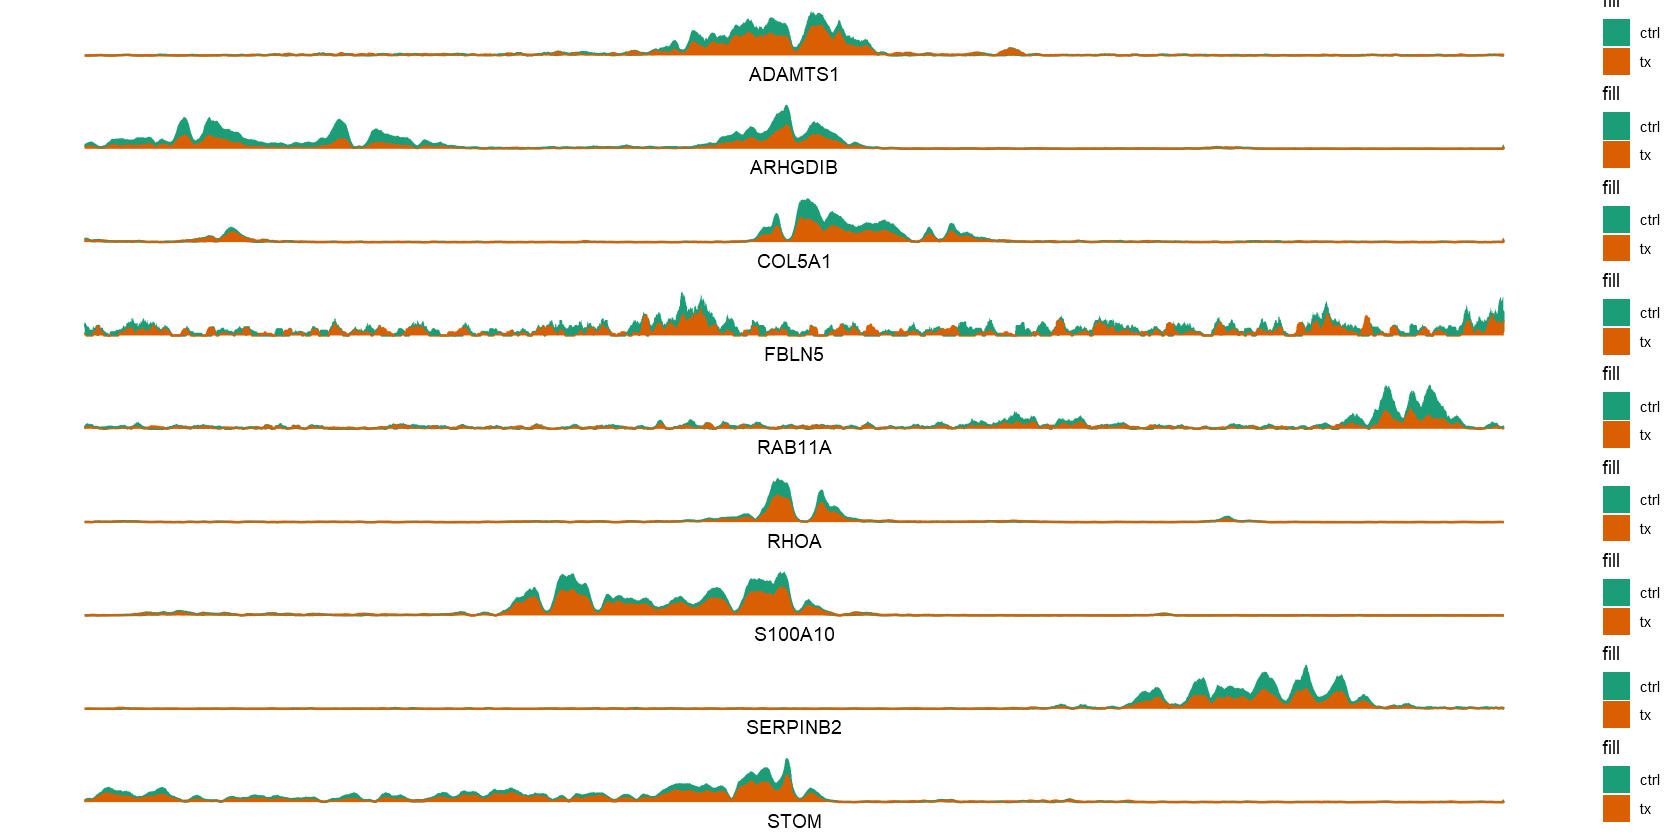

In [39]:
options(repr.plot.width=14, repr.plot.height=7)
go <- go[!duplicated(go$wikigene_name),]
name <- go$wikigene_name
chro <- as.character(go$chromosome_name)
TSS <- go$transcription_start_site
st <- (TSS - 15000)
en <- (TSS + 15000)
PSbw <- "./data/PSOS_H3K27ac/mergebam/merge_bigwig_files/PS.bw"
OSbw <- "./data/PSOS_H3K27ac/mergebam/merge_bigwig_files/OS.bw"

p1 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[1],
                         start <- st[1],
                         end <- en[1],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[1])#;p1
p2 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[2],
                         start <- st[2],
                         end <- en[2],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[2])#;p2
p3 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[3],
                         start <- st[3],
                         end <- en[3],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[3])#;p3
p4 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[4],
                         start <- st[4],
                         end <- en[4],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[4])#;p4
p5 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[5],
                         start <- st[5],
                         end <- en[5],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[5])#;p5
p6 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[6],
                         start <- st[6],
                         end <- en[6],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[6])#;p6
p7 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[7],
                         start <- st[7],
                         end <- en[7],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[7])#;p7
p8 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[8],
                         start <- st[8],
                         end <- en[8],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[8])#;p8
p9 <- ChiPseqPeakPlotter(treatment_bw <- PSbw,
                         control_bw <- OSbw,
                         chr <- chro[9],
                         start <- st[9],
                         end <- en[9],
                         average_dist <- 10,
                         fill_dist <- 10,
                         type = "all",
                         x_lab = name[9])#;p9
multiplot(p1, p2, p3, p4, p5, p6, p7, p8, p9, cols = 1)
tiff(file = "./results/18 combined_H3K27ac CHiPseq.tiff", width = 2000, height = 2500, units = "px", res = 300); multiplot(p1, p2, p3, p4, p5, p6, p7, p8, p9, cols = 1);dev.off()

## Identify post translational modification sites in proteins in the SARS-CoV-2 network

#### Obtain and clean protein sequences for genes in the SARS-CoV-2 network

In [40]:
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/proteomes/2016-4-29 Proteomes") # Windows
PROTan <- fread("3 Annotated species protein compilation.xls"); setwd(homedir)
PROTan$external_gene_name <- toupper(PROTan$external_gene_name)
TRANS_PROT <- PROTan[(PROTan$external_gene_name %in% ID2),]
Sorted_Proteins <- VariantSort(TRANS_PROT, variant = "MAX")
Sorted_Proteins[1:2,c(1, 3:7), with = FALSE]

  |======================================================================| 100%


ensembl_peptide_id,Species_File,Scientific_Name,Common_Name,external_gene_name,Length
<chr>,<chr>,<chr>,<chr>,<chr>,<int>
ENSAMEP00000000043,Ailuropoda_melanoleuca.ailMel1.pep.all.fa.gz,Ailuropoda_melanoleuca,Giant panda,HYOU1,998
ENSAMEP00000000283,Ailuropoda_melanoleuca.ailMel1.pep.all.fa.gz,Ailuropoda_melanoleuca,Giant panda,GDI1,447


#### Identify post translation modification sites in proteins in the SARS-CoV-2 network

In [41]:
# Load and annotate the post translational modification data table
setwd("C:/Users/breng/Dropbox/Brendan Documents/programming/bioinformatics/Post translation enzyme data base")
EZDT <- fread("2016-8-22 Post translational enzyme data table for R BG.csv", header = TRUE)
setwd(homedir)
EZDT <- EZDT[,.(Targeting_Factor, Consensus_Sequence)]
head(EZDT,2)
# Perform the moditication site matches
setnames(Sorted_Proteins, colnames(Sorted_Proteins),
         c("ensembl_peptide_id", "Sequence", "Species_File", "Scientific_Name", "Common_Name", "gene_symbol", "Length"))
PROT_TOT_Species <- TFpredict(Sorted_Proteins, EZDT, type = "multiple_species")
PROT_TOT_Species[1:2,c(1:6,8:11), with = FALSE]

Targeting_Factor,Consensus_Sequence
<chr>,<chr>
AMPK,(K|R|H)(F|L|M|I|V)(K|R|H)...(S|T)...(F|L|M|I|V)
AMPK,.(F|L|M|I|V)(K|R|H)...(S|T)...(F|L|M|I|V)


  |======================================================================| 100%


Consensus_Sequence,start,end,Number_Hits,Targeting_Factor,length,Identified_sequence,gene_symbol,Species,Scientific_Name
<chr>,<int>,<int>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
(F|I|L|M|V).(R)..(S|T),553,558,1,CaMKIV,998,SlirvesV,HYOU1,Giant panda,Ailuropoda_melanoleuca
(F|I|L|M|V).(R)..(S|T)(F|I|L|M|V),553,559,1,CaMKI,998,SlirvesvF,HYOU1,Giant panda,Ailuropoda_melanoleuca


#### Score, set minimum species conservation cutoff, and count the number of kinase binding sites for each promoter sequence

In [42]:
#### Retain only Posttranslational modification association conservation between for selected species for each protein ##
DT25 <- SpeciesTFCons(DT = PROT_TOT_Species,Spec = c("Human", "Mouse", "Rat"), provide = "TF_Target")
writab(DT=DT25, fname="./results/19 HMR Raw Posttranslational modification hits.xls")
#### Determine the number of times each Protein consensus sequence is present for each target in human 
TF_ABUN <- TFRankR(DT = DT25, sortBy = "abundance", dec = TRUE)
TF_ABUN <- TF_ABUN[TF_ABUN$Species == "Human",]
head(TF_ABUN, 2)
writab(DT=TF_ABUN, fname="./results/20 protein number of consensus sequences Human.xls")
#### Determine the number of targets contain a consensus sequence for each posttranslational modifying enzyme in human
TF_PROM <- TFRankR(DT = DT25, sortBy = "Target", dec = TRUE)
TF_PROM <- TF_PROM[TF_PROM$Species == "Human",]
head(TF_PROM, 2)
writab(DT=TF_PROM, fname="./results/21 protein number of promoters Human.xls")

Number_Hits,Targeting_Factor,gene_symbol,Species
<int>,<chr>,<chr>,<chr>
42,MSK1,DNMT1,Human
42,MSK2,DNMT1,Human


Targeting_Factor,Number_targets,Species
<chr>,<int>,<chr>
AMPK,109,Human
MSK1,99,Human


#### Plot the number of proteins targeted by each kinase

png 
  2

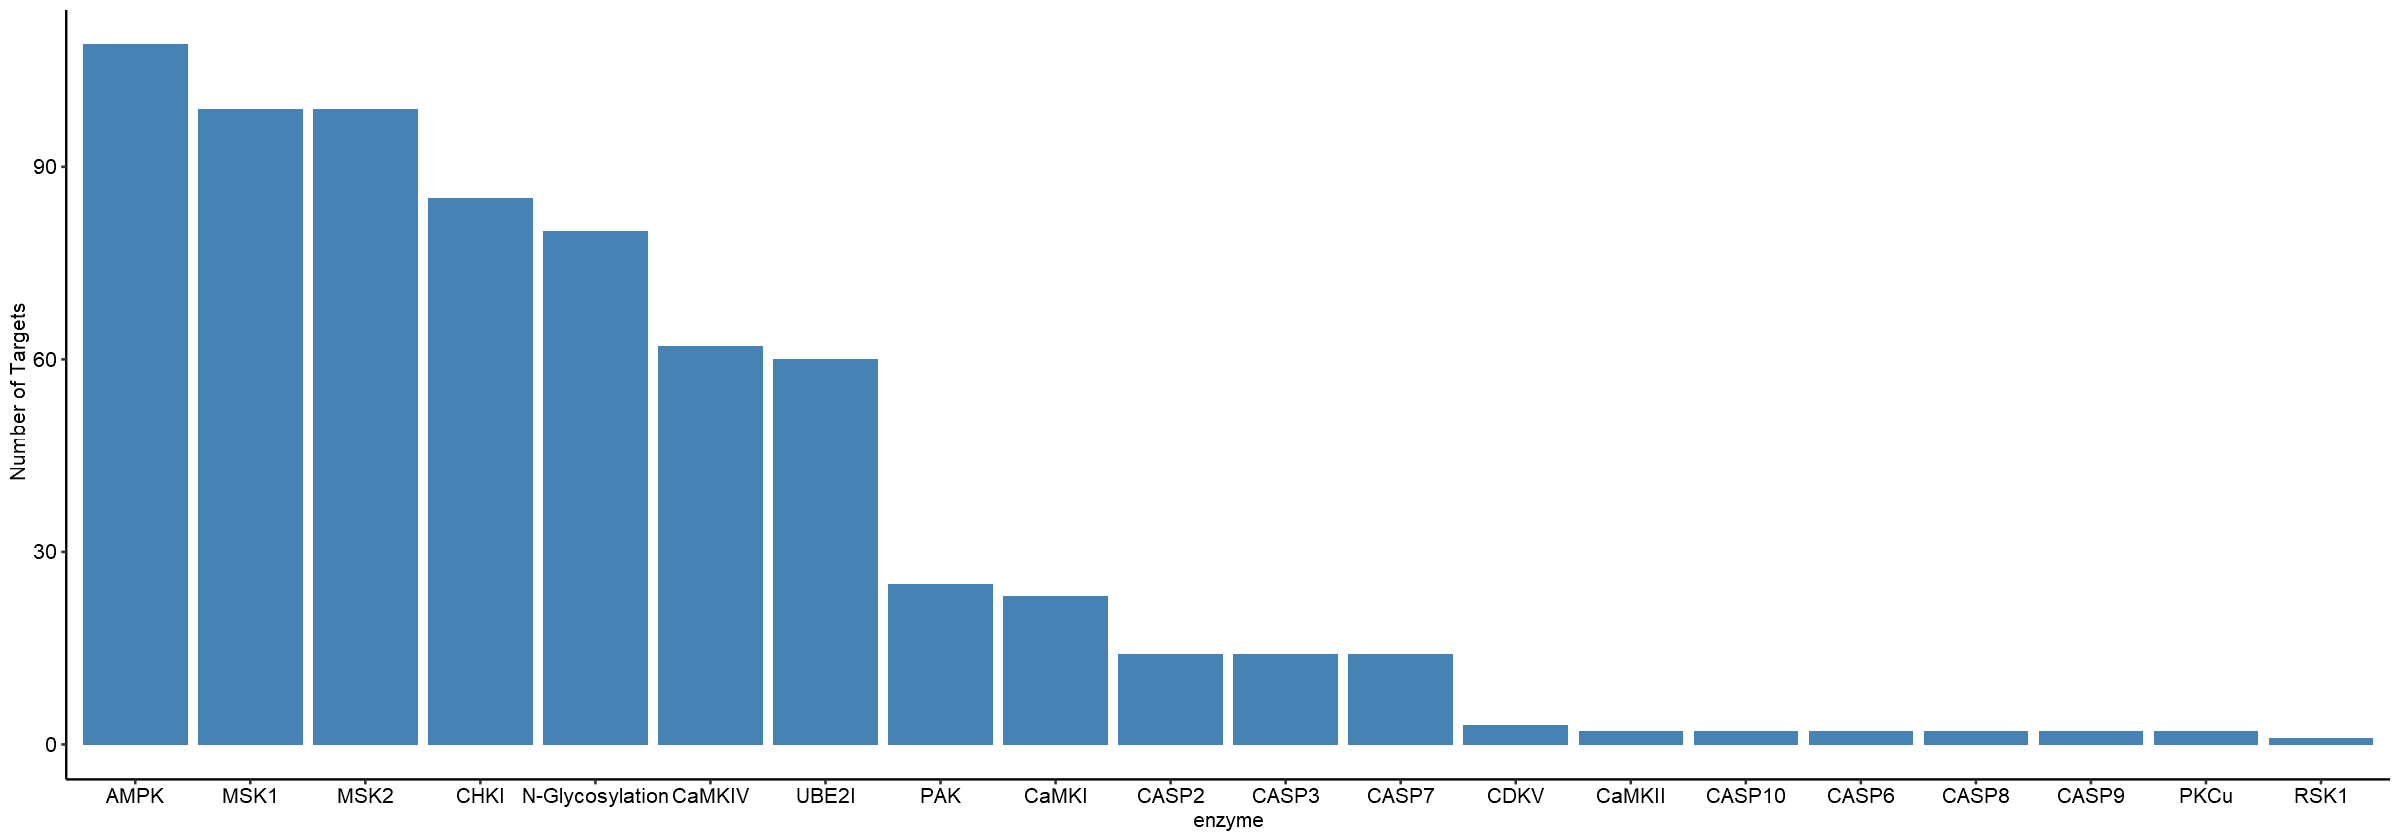

In [43]:
options(repr.plot.width=20, repr.plot.height=7)
g1<-ggplot(data=TF_PROM, aes(x=reorder(`Targeting_Factor`,-Number_targets), y=Number_targets)) +
    geom_bar(stat="identity", fill="steelblue") + theme_pubr()+xlab("enzyme")+ylab("Number of Targets")
g1
tiff(file = "./results/22 shear kinase number of targets.tiff", width = 2000, height = 500, units = "px", res = 100);g1;dev.off()

#### End of Analysis